(page:gcns)=
# Generalized Coordination Numbers

This script calculates the generalized coordination number for an atomic configuration delivered in the `.bgf` format. Generalized coordination numbers (GCNs) were first introduced by [Calle-Vallejo et al.](https://onlinelibrary.wiley.com/doi/abs/10.1002/anie.201402958)

The GCN of an atom $x$ is calculated as the normalized sum over the [classical CNs](page:cns) of all its nearest neighbor atoms $y$. Similar to the classical CN analysis, a cutoff value, $r_\mathrm{c}$, is used to identify the nearest neighbors. The normalization factor depends on the crystal lattice that the system was derived from and indicates the maximum number of nearest neighbors (12 for fcc, 8 for bcc, etc.). 

GCNs allow for a more detailed analysis of the coordination environment. For example: unlike [classical CNs](page:cns), GCNs can differentiate between the hcp and fcc adsorption sites on the (111)-indexed facets of this octahedral nanoparticle.

The first steps are analogous to the process detailed for the [classical CNs](page:cns). We will therefore keep this part short until the point where the approaches diverge. Check the [classical CNs](page:cns) page for more detailed explanations.

First, read in the data.

In [33]:
import pandas as pd

data = pd.read_csv("../data/data.csv")

Pick a (non-oxidized) sample system and read the structure into an `Atoms` object using the `read_bgf` function from the [asetools package](https://gitlab.com/bjk24/asetools.git). Then, set the $r_\mathrm{c}$ cutoff parameter and `probe` element, and generate the `indices` list holding all relevant atomic indices.

In [34]:
from asetools.systemtools import read_bgf

sample = data.loc[(data["n_O"] == 0)].iloc[0]
atoms = read_bgf(sample["root"])
rc = 3.0
probe = "Pt"
indices = [atom.index for atom in atoms if atom.symbol == probe]

Generalized coordination numbers require a normalization factor, `cnmax`, which is the maximum number of bonds an atom can have in this particular crystal structure. For Pt, a fcc metal, this value is 12.

In [35]:
cnmax = 12

From hereon, the GCN implementation diverges from the [classical CN](page:cns). Not only do we need to calculate the CN for each atom, we also need to keep track of the atomic indices of each atom's neighbors because the GCN is a normalized sum over the classical CNs of each atom's neighbors. Here, we create a `neighborList` object which holds the atomic indices of the neighbors of each atom. The classical CN of each atom then is the length of the corresponding `neighborList` entry.

In [36]:
neighborList = {}
for idx in indices:

    # Calculate all distances.
    dists = atoms.get_distances(idx, indices)

    # Initialize empty list for current atom index.
    neighborList.update({idx: []})

    # Add indices of neighbor atoms to the list.
    for i, d in enumerate(dists):
        if d > 0 and d <= rc:
            neighborList[idx].append(indices[i])

We'll have a look at a couple of entries from both the `neighborList` and the `cnDict` dictionaries.

In [37]:
for i in range(5):
    print("neighbors of atom ", i, ":", neighborList[i])
    print("CN of atom ", i, ":", len(neighborList[i]))

neighbors of atom  0 : [1, 2, 3, 6, 9, 10, 19]
CN of atom  0 : 7
neighbors of atom  1 : [0, 2, 4, 6, 15, 16, 19]
CN of atom  1 : 7
neighbors of atom  2 : [0, 1, 3, 4]
CN of atom  2 : 4
neighbors of atom  3 : [0, 2, 4, 10, 19, 20, 23]
CN of atom  3 : 7
neighbors of atom  4 : [1, 2, 3, 16, 19, 20, 27]
CN of atom  4 : 7


Looks reasonable. We will now generate yet another `dictionary` object, this time to hold the GCN for each atomic index. 

To this end, we loop over `neighborList`, which contains all atomic indices to be analyzed as the `key`. Then, we loop over the `values` for each `key`, which are the atomic indices of the neighbors. The CNs are calculated as the length of the `values` list; these get summed up and normalized by `cnmax` to give the GCN. 

Also, note that we round the GCN to 1 digit - change this value to get a finer resolution.

In [38]:
gcnDict = {}
for idx, neighbors in neighborList.items():
    gcn = 0.
    for nidx in neighbors:
        gcn += len(neighborList[nidx]) / cnmax
    gcnDict.update({idx: round(gcn, 1)})

Let's sanity-check the results. We use the `set` function to get an overview over all unique GCNs generated by the above code.

In [39]:
print(set(gcnDict.values()))

{2.3, 4.6, 5.2, 6.8, 7.2, 7.5, 9.3, 10.6, 11.2, 12.0}


Looks decent. The `cnmax` normalization factor makes sure that 12 is still the maximum for this fcc metal. 

As we did for the [classical CNs](page:cns), we can visualize the GCNs on the structure itself. The same caveats as [before](page:cns) apply: we need to translate the system's coordinates to make it display properly due to limitations of the "x3d" viewer.

To make things a bit more interesting, let's also introduce a cutting plane and remove all atoms that are above a certain $z$ value. This way we can see the cross section of the structure. To this end, we exploit the `ase.Atoms.get_center_of_mass` function and use the $z$ component of the position vector it returns as the cutting plane.

In [40]:
from ase.visualize import view
from ase.data import chemical_symbols

center = atoms.cell.diagonal() / 2
atoms.translate((-1) * center)
atoms.translate([0,0,-35])

# Change "color".
for idx, gcn in gcnDict.items():
    atoms[idx].symbol = chemical_symbols[round(gcn * 5)]

# Use COM as cutting plane to remove certain atoms.
com = atoms.get_center_of_mass()
select = [atom.index for atom in atoms if atom.position[2] < com[2] + 0.3]

view(atoms[select], viewer="x3d")

From this visualization, we can see that the resolution is significantly finer compared to the classical CNs. In particular, GCNs do not immediately reach the bulk value (12) starting from the first layer below the surface. This behavior is more in line with chemical intuition: surface properties decline fast but not instantaneously.

Next, we visulize the distribution. Count how often each GCN occurs.

In [41]:
gcnDist = {}
for gcn in gcnDict.values():
    if gcn in gcnDist:
        gcnDist[gcn] += 1
    else:
        gcnDist.update({gcn: 1})
print(gcnDist)

{4.6: 24, 2.3: 6, 5.2: 60, 6.8: 24, 7.2: 96, 10.6: 60, 9.3: 6, 7.5: 48, 11.2: 80, 12.0: 85}


We see familiar patterns in this data, albeit more differentiated than [before](page:cns). There are 6 atoms with GCN = 2.3 which are the vertex atoms. The edge atoms are characterized by GCN values between 4.6 and 6.8 while the facet atoms have GCNs of 7.2 up to 7.5. Subsurface and bulk atoms have GCNs between 10.6 and 12.0. 

Finally, let's visualize the distribution as a bar chart.

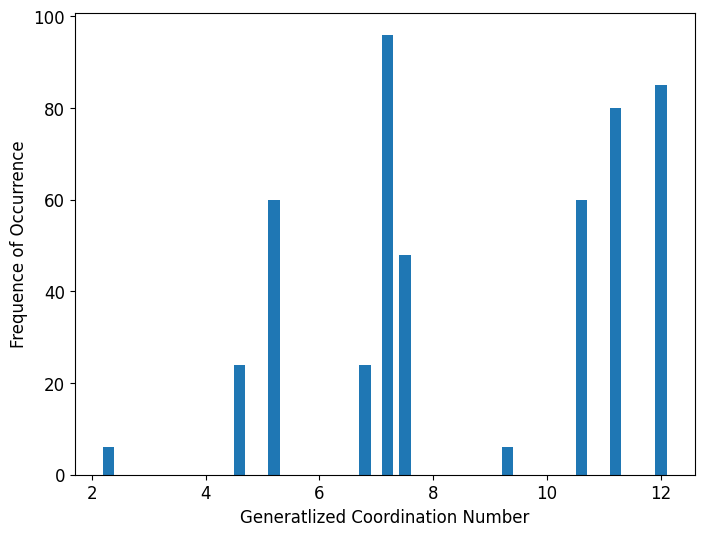

In [42]:
import matplotlib.pyplot as plt

keys, values = zip(*gcnDist.items())

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 12})
plt.bar(keys, values, width=0.2)
plt.xlabel("Generatlized Coordination Number")
plt.ylabel("Frequence of Occurrence")
plt.show()